# Python notebook to plot apical region response to stimulation.
Assumes folder directory structure:
<pre><code>  IMAGING
    image_stacks
    notebooks
    results
</code></pre>
Execute the code sequentially, one block at a time, using &lt;shift-return&gt;.

In [110]:
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import numpy as np
import csv
import datetime
from skimage import io
from skimage import exposure
from skimage.util import img_as_float32
from skimage.morphology import binary_erosion, binary_dilation
from skimage.morphology import remove_small_objects
from skimage.measure import label, regionprops


#### User editable parameters.
Take care with formatting!\
NOTE: The time-stamped results directory is created in this code block.

In [111]:
################################################################################
################################################################################

# user editable parameters

# stimulation frequency, file posfix
image_files = {
  #1: ".tif",
  #2: "_0001.tif",
  5: "_ORIG.tif",
  10: ".tif"
}
results_prefix = "warped"  # base data file name

roi_freq = 10             # simulation frequency to use for generating roi's (5)
roi_quantile = 0.95      # roi threashold (0.98)

small_object = 30        # small object size to cull (16)
dilations = 2            # number of dilations to apply (2)

image_bits = 10          # bits per pixel (can be found in the oir meta data) (10)
sample_period = 0.1      # image data sample time period in seconds (0.1)
stim_start = 150         # stimulation start frame (100)
stim_done = 360          # stimulation end frame (including decay?) (250)

# uncomment one method
#method = "average"
method = "std"

################################################################################
################################################################################

# create timestamped results directory
if not os.path.exists("../results"):
  os.mkdir("../results")
resultsdir = str(datetime.datetime.now())[:-7]
resultsdir = resultsdir.replace('-', '').replace(' ', '-').replace(':','')
resultsdir = "../results/" + results_prefix + resultsdir
os.mkdir(resultsdir)


#### User editable lookup table for image plot colors.
For a list of predefied colormaps refer to:
https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html \
To create your own custom colormap refer to:
https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html


In [112]:
# look up table for image plot color
#   e.g. coolwarm, jet, plasma, gray
lut = mpl.cm.coolwarm


#### Get the image stack.


In [113]:
# get the image stack for roi's
A0 = io.imread("../image_stacks/" + results_prefix + image_files[roi_freq])
A0 = np.float32(A0/(2.0**image_bits))

# average out y-direction aliasing over every other line
for n in range(A0.shape[0] - 1): # moving average over every two lines
  A0[n] = (A0[n] + A0[n+1]) / 2.0


#### Unstimulated average (or standard deviation) over time.


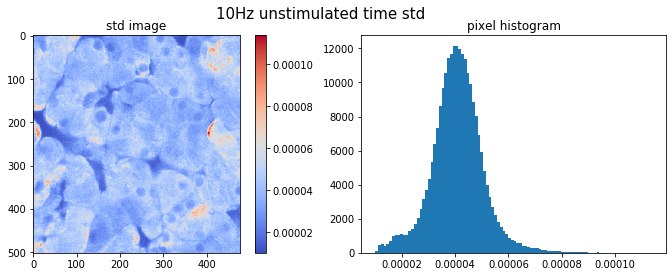

In [114]:
# unstimulated average or std over time
A = np.concatenate((A0[:stim_start-1,:,:], A0[stim_done:,:,:])) # unstimulated only
if method == "std":
  M = np.std(A, axis=0)
else:
  M = np.mean(A, axis=0)

# plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [12, 4])
fig.suptitle(str(roi_freq) + "Hz unstimulated time " + method , fontsize=15)

cs = ax[0].imshow(M, norm=None, cmap=lut.name) # image
ax[0].set_title(method + " image")
if method == "std":
  fig.colorbar(cs, ax=ax[0])
elif method == "average":
  norm = mpl.colors.Normalize(vmin=0, vmax=1)
  v = mpl.cm.ScalarMappable(norm=norm, cmap=lut)
  fig.colorbar(v, ax=ax[0], orientation='vertical', label='pixel intensity')

ax[1].hist(M.flatten(), bins=100) # histogram
ax[1].set_title("pixel histogram")
fig.savefig(resultsdir + "/" + str(roi_freq) + "Hz-unstimulated_time_" + method + ".pdf")
plt.show()


#### Stimulated average (or standard deviation) over time.


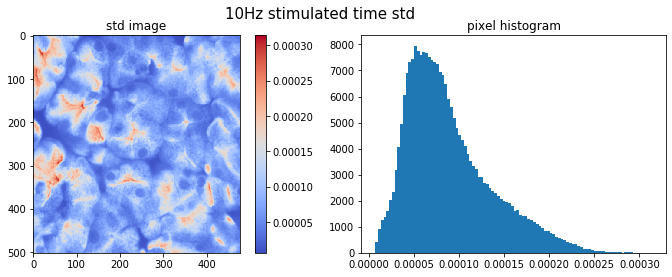

In [115]:
# stimulated average or std over time
A = A0[stim_start-1:stim_done-1,:,:] # stimulated only
if method == "std":
  N = np.std(A, axis=0)
elif method == "average":
  N = np.mean(A, axis=0)

# plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [12, 4])
fig.suptitle(str(roi_freq) + "Hz stimulated time " + method, fontsize=15)

cs = ax[0].imshow(N, norm=None, cmap=lut.name) # image
ax[0].set_title(method + " image")
if method == "std":
  fig.colorbar(cs, ax=ax[0])
elif method == "average":
  norm = mpl.colors.Normalize(vmin=0, vmax=1)
  v = mpl.cm.ScalarMappable(norm=norm, cmap=lut)
  fig.colorbar(v, ax=ax[0], orientation='vertical', label='pixel intensity')

ax[1].hist(N.flatten(), bins=100) # histogram
ax[1].set_title("pixel histogram")
fig.savefig(resultsdir + "/" + str(roi_freq) + "Hz-stimulated_time_" + method + ".pdf")
plt.show()


#### Stimulated minus unstimulated average (or standard deviation) over time.


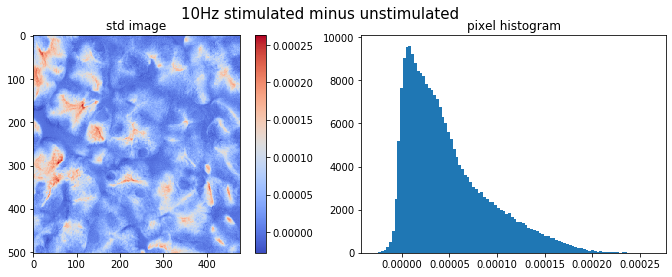

In [116]:
# difference: stimulated - unstimulated
O = N - M

# plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [12, 4])
fig.suptitle(str(roi_freq) + "Hz stimulated minus unstimulated", fontsize=15)

cs = ax[0].imshow(O, norm=None, cmap=lut.name) # image
fig.colorbar(cs, ax=ax[0])
ax[0].set_title(method + " image")

ax[1].hist(O.flatten(), bins=100) # histogram
ax[1].set_title("pixel histogram")
fig.savefig(resultsdir + "/" + str(roi_freq) + "Hz-stimulated_minus_unstimulated.pdf")
plt.show()


#### Create apical region-of-interest mask.


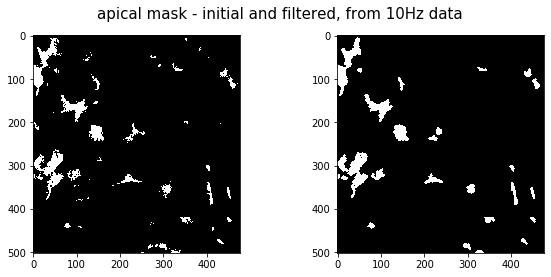

stimulation frequency: 10Hz
number of apical regions identified:  25
apical ROI labels:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
apical ROI pixel counts:  [2502  146   89  238  219  257 1487  981  196  158 2832  130  452   71
  451  115  425  314  187  243  112  156  136  190   97]



In [117]:
os.system("rm " + resultsdir + "/apical_region*.*") # delete all exiting region files

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [10, 4])
fig.suptitle("apical mask - initial and filtered, from " + str(roi_freq) + "Hz data", fontsize=15)

# difference threashold filter
P = (O > np.quantile(O,roi_quantile)).astype(float)

# plot image
ax[0].imshow(P, norm=None, cmap='gray');
io.imsave(resultsdir + "/" + str(roi_freq) + "Hz-apical_mask_initial.png", 255*np.uint8(P), check_contrast=False)

# filtering: erosion, remove small, then dilation
Q = binary_erosion(P)
Q = remove_small_objects(Q, small_object)
for i in range(dilations):
  Q = binary_dilation(Q)

ax[1].imshow(Q, norm=None, cmap='gray') # plot image
io.imsave(resultsdir + "/" + str(roi_freq) + "Hz-apical_mask_filtered.png", 255*np.uint8(Q), check_contrast=False)
plt.show()

# label and get pixel counts
R, n = label(Q, return_num=True)
io.imsave(resultsdir + "/" + str(roi_freq) + "Hz-apical_mask_labelled.tif", np.int16(R), check_contrast=False)
ROI, COUNT = np.unique(R, return_counts=True)
print("stimulation frequency: " + str(roi_freq) + "Hz")
print("number of apical regions identified: ", ROI.shape[0]-1)
print("apical ROI labels: ", ROI[1:])
print("apical ROI pixel counts: ", COUNT[1:])
print()

#### FOR REFERENCE: Annotate the apical mask regions by number.

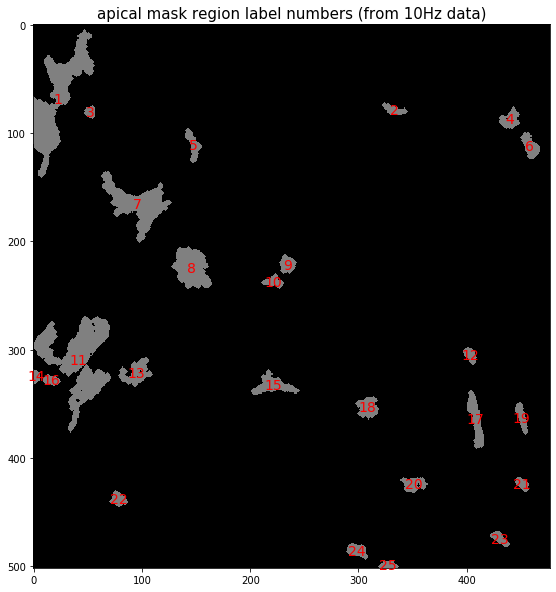

In [118]:
# start with the filtered image...
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 10])
ax.imshow(Q, norm=None, vmax=2, cmap='gray') # dim the white a bit, easier to see the annnotations
ax.set_title("apical mask region label numbers (from " + str(roi_freq) + "Hz data)", fontsize=15)

# annotate each region with its label number 
for props in regionprops(R):
  y, x = props.centroid # get the centroid for each region
  t = ax.text(x, y, str(props.label), ha='center', va='center', size=14, c='r')
fig.savefig(resultsdir + "/" + str(roi_freq) + "Hz-apical_mask_annotated.pdf")
plt.show()


#### DIAGNOSTIC: Plot apical region responses for the same stimulation frequency used to generate the mask.


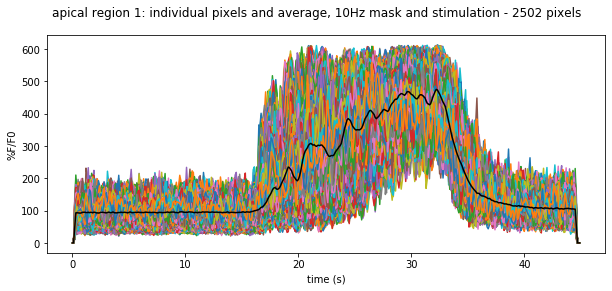

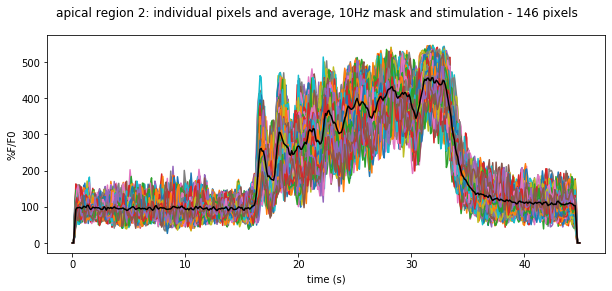

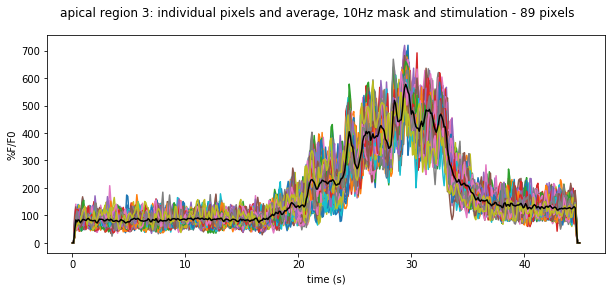

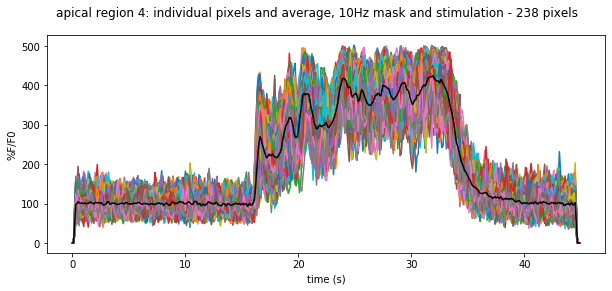

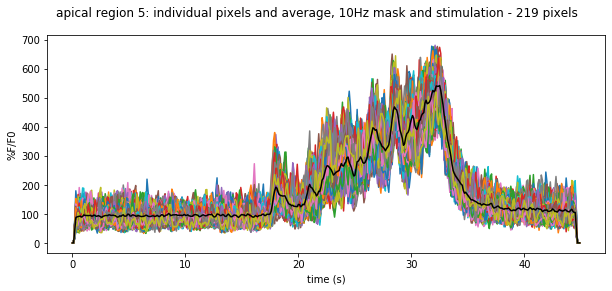

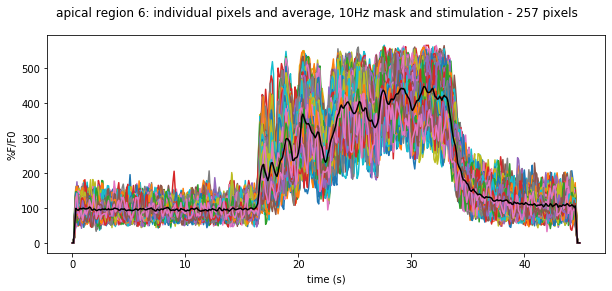

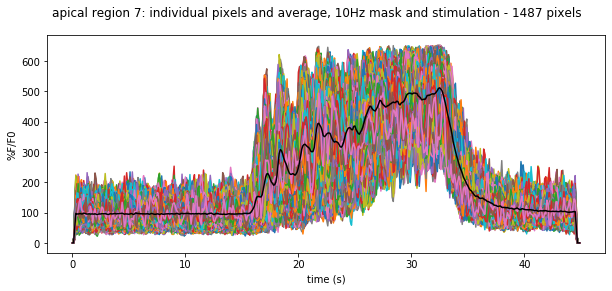

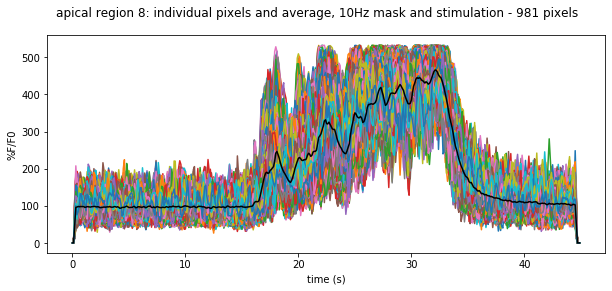

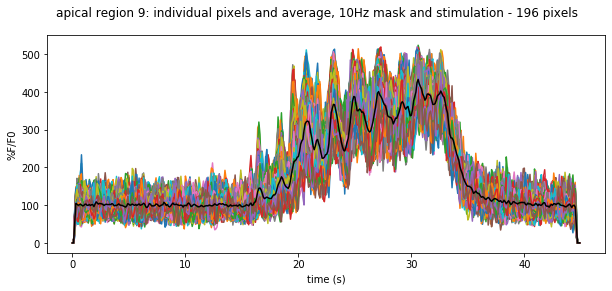

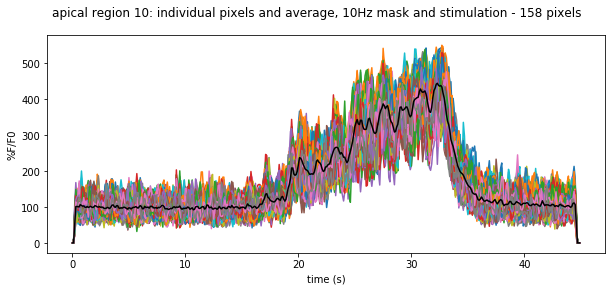

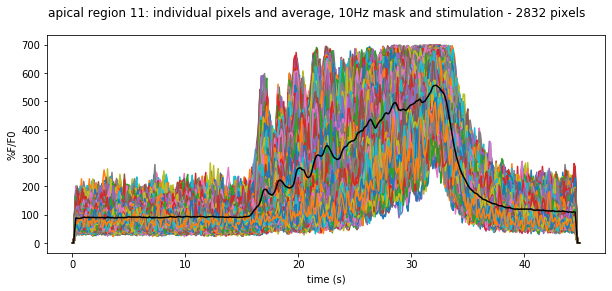

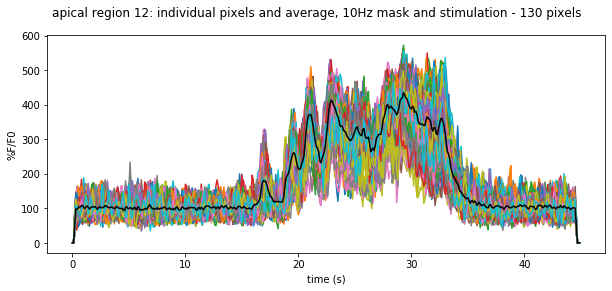

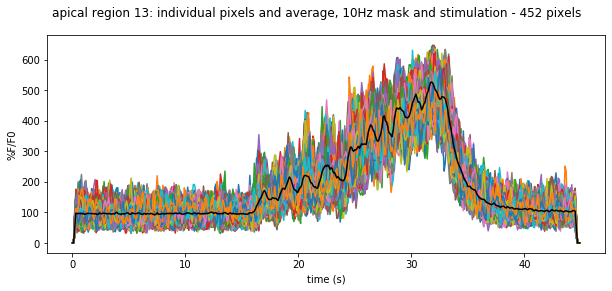

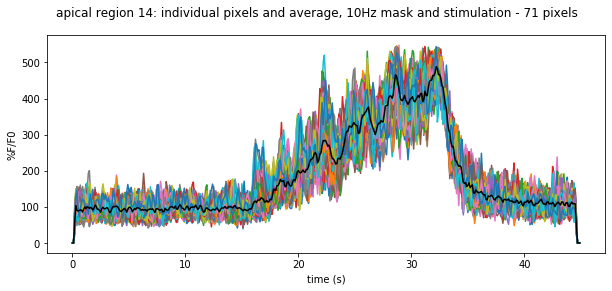

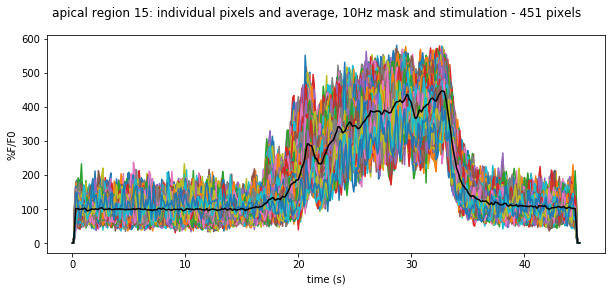

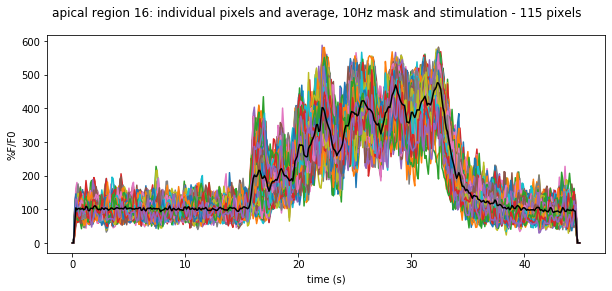

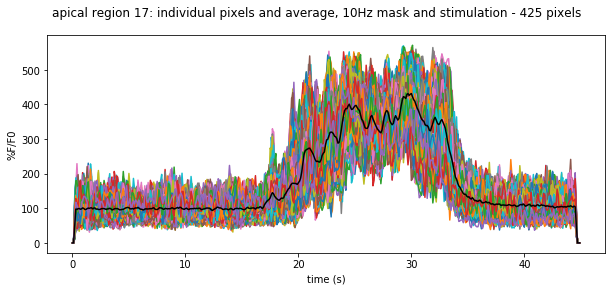

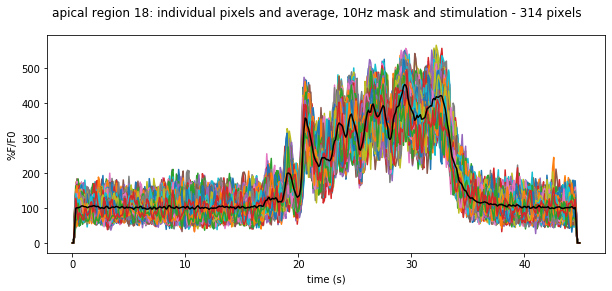

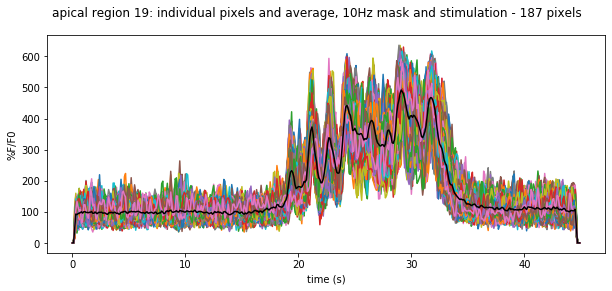

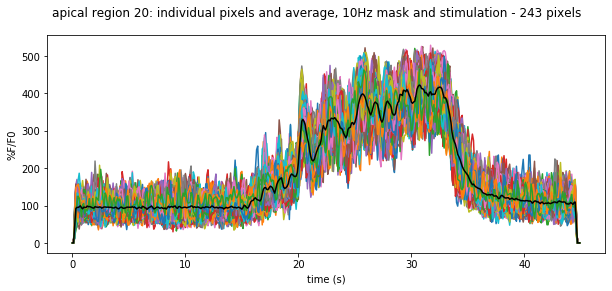

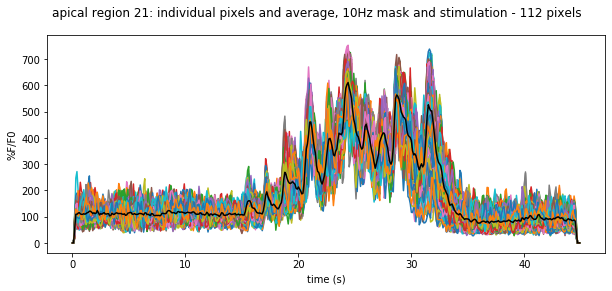

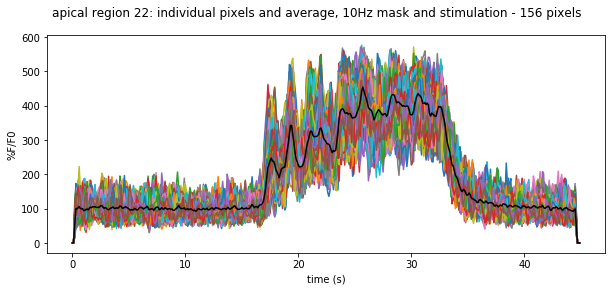

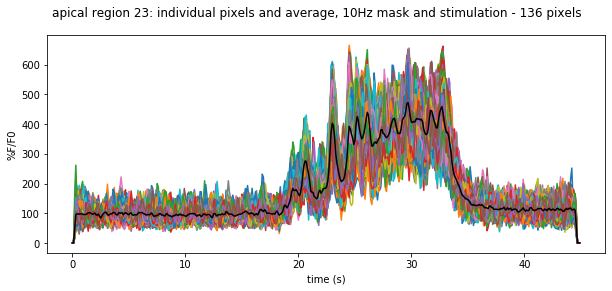

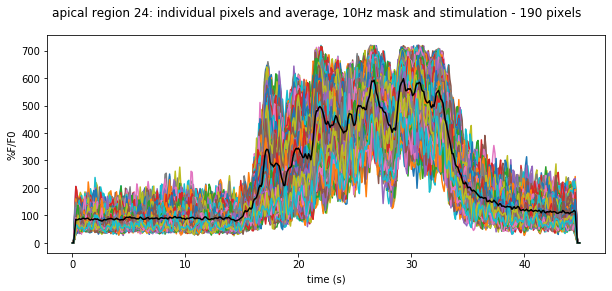

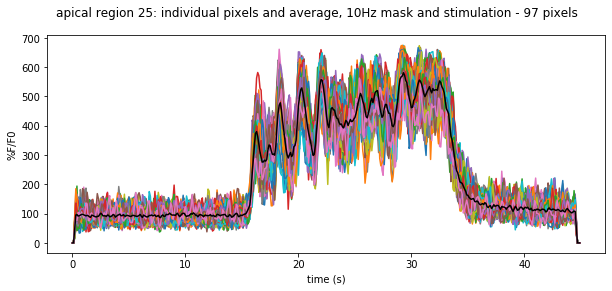

In [119]:
# apical region plots using the mask
X = np.array(range(A0.shape[0])) * sample_period # the timebase

# create and save plots
for c in ROI:
  if(c==0):
    continue
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
  fig.suptitle('apical region ' + str(c)+ ": individual pixels and average, " + str(roi_freq) + "Hz mask and stimulation - " +str(COUNT[c]) + " pixels")

  A = np.concatenate((A0[:stim_start-1,:,:], A0[stim_done:,:,:])) # unstimulated only
  M = np.mean(A, axis=0)
  F0 = np.mean(M[R==ROI[c]]) # per region 
  #F0 = M[R==ROI[c]] # per pixel
  S = 100 * A0[:, R==ROI[c]] / F0
  T = np.sum(S, axis=1) / S.shape[1]
  ax.plot(X, S)
  ax.plot(X, T, color='black')
  ax.set(ylabel="%F/F0")
  ax.set(xlabel="time (s)")

  # save figure to pdf
  s = "/apical_region_" + str(c) + "-mask" + str(roi_freq) + "Hz" + "-stim" + str(roi_freq) + "Hz.pdf"
  fig.savefig(resultsdir + s)
  
  plt.show()
  plt.close() # frees up memory



#### RESULTS: Plot responses for all stimulation frequencies and regions using the mask from above.
#### Save responses to CSV files.
NOTE: The first CSV column is the time base, followed by a column for each stimulation frequency.

In [ ]:
# calculate, plot and save region responses for all stimulation frequencies

# calculate all of the results
RESULTS = np.zeros((len(image_files), ROI.shape[0]-1, A0.shape[0])) # array for all of the apical results
X = np.array(range(RESULTS.shape[2])) * sample_period # the timebase
for i in image_files:
  # get image stack
  A0x = io.imread("../image_stacks/" + results_prefix + image_files[i])
  A0x = np.float32(A0x/(2.0**image_bits))

  # average out y-direction aliasing over every other line
  for n in range(A0x.shape[0] - 1): # moving average over every two lines
    A0x[n] = (A0x[n] + A0x[n+1]) / 2.0

  Ax = np.concatenate((A0x[:stim_start-1,:,:], A0x[stim_done:,:,:])) # unstimulated only
  Mx = np.mean(Ax, axis=0)

  for c in ROI:
    if(c==0):
      continue
    F0 = np.mean(Mx[R==ROI[c]]) # per region 
    S = 100 * A0x[:, R==ROI[c]] / F0
    T = np.sum(S, axis=1) / S.shape[1]
    RESULTS[list(image_files).index(i), c-1] = T # save in the results array

# plot and save responses for all the stimulation frequencies by region
for n in range(1,len(ROI)):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
  fig.suptitle('apical region ' + str(ROI[n]) + ": mask "+ str(roi_freq) + "Hz, " + str(COUNT[n]) + " pixels")

  ax.plot(X, np.transpose(RESULTS[:, n-1, :]))
  ax.set(ylabel="%F/F0")
  ax.set(xlabel="time (s)")
  ax.legend(list('{:d}Hz'.format(x) for x in image_files.keys()))

  # save figure to pdf
  fig.savefig(resultsdir + "/apical_region_" + str(n) + "-mask" + str(roi_freq) + "Hz-stimALL.pdf")
    
  plt.show()
  plt.close() # frees up memory

  # save responses to CSV file
  with open (resultsdir + "/apical_region_" + str(n) + "-mask" + str(roi_freq) + "Hz-stimALL.csv", 'w') as file:
    writer = csv.writer(file)
    for i in range(RESULTS.shape[2]):
      t = np.append(X[i], RESULTS[:,n-1,i])
      writer.writerow('{:3.3e}'.format(x) for x in t)

# plot average of region responses for all the stimulation frequencies
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
fig.suptitle("average over all apical regions, mask "+ str(roi_freq) + "Hz")

Y = np.transpose(np.sum(RESULTS, axis=(1)))/RESULTS.shape[1]
ax.plot(X, Y)
ax.set(ylabel="%F/F0")
ax.set(xlabel="time (s)")
ax.legend(list('{:d}Hz'.format(x) for x in image_files.keys()))

# save figure to pdf
fig.savefig(resultsdir + "/apical_region_AVG-mask" + str(roi_freq) + "Hz-stimALL.pdf")
    
plt.show()
plt.close() # frees up memory

# save average of responses to CSV file
with open (resultsdir + "/apical_region_AVG-mask" + str(roi_freq) + "Hz-stimALL.csv", 'w') as file:
  writer = csv.writer(file)
  for i in range(X.shape[0]):
    t = np.append(X[i], Y[i])
    writer.writerow('{:3.3e}'.format(x) for x in t)

